In [1]:
import numpy as np
import pandas as pd
import torch.nn as nn

In [11]:
# read data
data = pd.read_csv('data/small.csv')
# convert all data to ints
data = data.astype(int)
print(data.head())

    s  a  r  sp
0  61  1  0  61
1  61  1  0  61
2  61  2  0  51
3  51  1  0  51
4  51  4  0  41


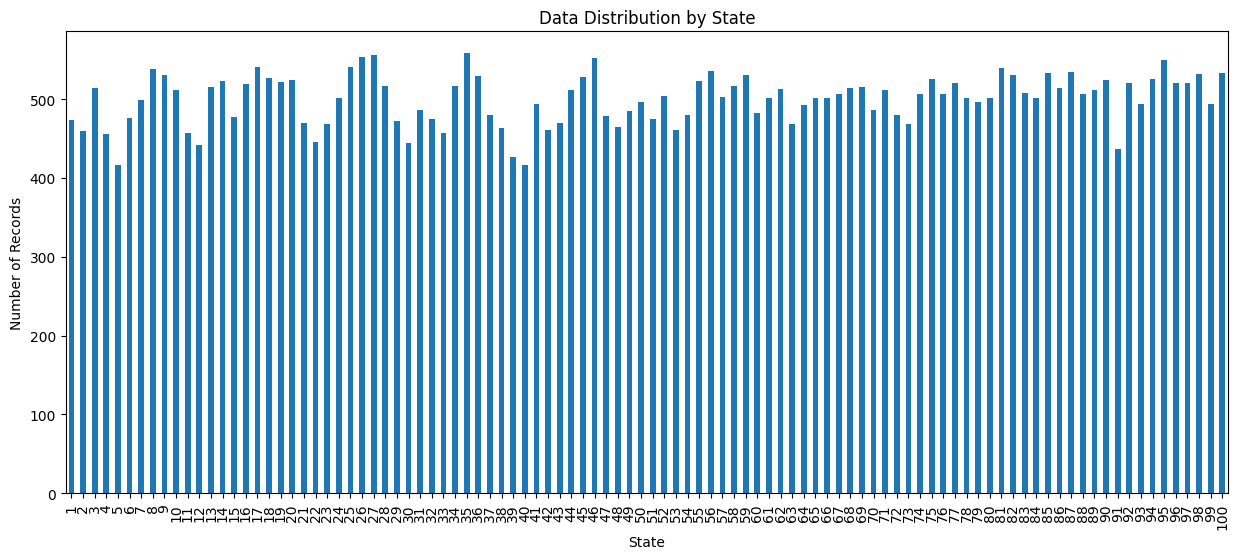

In [ ]:
# plot how much data we have for each state
import matplotlib.pyplot as plt
plt.figure(figsize=(15,6))
state_counts = data['s'].value_counts()
# sort by state number
state_counts = state_counts.sort_index()
# if any states are missing (i.e. no data for that state), add them with count 0
for state in range(state_counts.index.min(), state_counts.index.max() + 1):
    if state not in state_counts:
        state_counts[state] = 0
state_counts = state_counts.sort_index()
state_counts.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Number of Records')
plt.title('Data Distribution by State')
plt.show()

As we can see, all states have a high data representation, so we can go ahead and do Q-learning.

# Q Learning

In [47]:
q_table = np.zeros((100, 4))  # 100 states and 4 actions
alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epochs = 10
for epoch in range(epochs):
    for _, row in data.sample(frac=1, random_state=epoch).iterrows():
        s = row['s'] - 1 # since states are 1-indexed in the data
        a = row['a'] - 1 # since actions are 1-indexed in the data
        r = row['r']
        s_next = row['sp'] - 1 # since states are 1-indexed in the data
        q_table[s, a] = q_table[s, a] + alpha * (r + gamma * np.max(q_table[s_next]) - q_table[s, a])

policy = np.argmax(q_table, axis=1) + 1 # convert back to 1-indexed

# output to a file 
with open('small.policy', 'w') as f:
    for _, action in enumerate(policy):
        f.write(f"{action}\n")

In [ ]:
q_table = np.zeros((100, 4))  # 100 states and 4 actions
alpha = 0.1  # learning rate
gamma = 0.95  # discount factor
epochs = 10
for epoch in range(epochs):
    for _, row in data.sample(frac=1, random_state=epoch).iterrows():
        s = row['s'] - 1 # since states are 1-indexed in the data
        a = row['a'] - 1 # since actions are 1-indexed in the data
        r = row['r']
        s_next = row['sp'] - 1 # since states are 1-indexed in the data
        q_table[s, a] = q_table[s, a] + alpha * (r + gamma * np.max(q_table[s_next]) - q_table[s, a])

policy = np.argmax(q_table, axis=1) + 1 # convert back to 1-indexed

# output to a file 
with open('small.policy', 'w') as f:
    for _, action in enumerate(policy):
        f.write(f"{action}\n")

In [39]:
alpha = 0.2
# decay_rate = 0.99
gamma = 0.95  # discount factor
Q1, Q2 = np.zeros((100,4)), np.zeros((100,4))
for epoch in range(1000):
    old_Q1, old_Q2 = Q1.copy(), Q2.copy()
    for _, row in data.iterrows():
        s, a, r, sp = row['s']-1, row['a']-1, row['r'], row['sp']-1
        if np.random.rand() < 0.5:
            next_a = np.argmax(old_Q1[sp])
            target = r + gamma * old_Q2[sp, next_a]
            Q1[s, a] += alpha * (target - Q1[s, a])
        else:
            next_a = np.argmax(old_Q2[sp])
            target = r + gamma * old_Q1[sp, next_a]
            Q2[s, a] += alpha * (target - Q2[s, a])
Q = (Q1 + Q2) / 2

In [41]:
policy = np.argmax(Q, axis=1) + 1 # convert back to 1-indexed

# output to a file 
with open('small.policy', 'w') as f:
    for _, action in enumerate(policy):
        f.write(f"{action}\n")

In [43]:
# Hyperparameters
gamma = 0.95
alpha = 0.1          # Q-learning step size
alpha_cql = 0.1      # weight for conservative penalty
n_epochs = 500

# Initialize Q-table and counts
Q = np.zeros((100, 4))
counts = np.zeros((100, 4))

# Count how often each (s,a) occurs
for _, row in data.iterrows():
    s = int(row['s']) - 1
    a = int(row['a']) - 1
    counts[s, a] += 1

empirical_probs = counts / (counts.sum(axis=1, keepdims=True) + 1e-8)

for epoch in range(n_epochs):
    Q_old = Q.copy()

    # Shuffle dataset for SGD-like updates
    for _, row in data.sample(frac=1, random_state=epoch).iterrows():
        s = int(row['s']) - 1
        a = int(row['a']) - 1
        r = float(row['r'])
        sp = int(row['sp']) - 1

        # Standard Bellman target
        y = r + gamma * np.max(Q_old[sp])

        # Conservative penalty:
        # Penalize Q(s,a) being higher than average over all actions
        mean_q_all = np.mean(Q[s])          # average over all actions
        q_data = Q[s, a]                    # Q of observed action
        conservative_penalty = mean_q_all - q_data

        # Update rule (CQL)
        Q[s, a] += alpha * ((y - Q[s, a]) - alpha_cql * conservative_penalty)

    delta = np.abs(Q - Q_old).max()
    if epoch % 20 == 0:
        print(f"Epoch {epoch:3d}: max ΔQ = {delta:.6f}")
    if delta < 1e-5:
        print(f"Converged at epoch {epoch}")
        break

# Derive policy: pick highest Q for each state
policy = np.argmax(Q, axis=1) + 1

# Save policy and Q-table
with open('small.policy', 'w') as f:
    for action in policy:
        f.write(f"{action}\n")

Epoch   0: max ΔQ = 10.000003
Epoch  20: max ΔQ = 5.956349
Epoch  40: max ΔQ = 3.879957
Epoch  60: max ΔQ = 8.594276
Epoch  80: max ΔQ = 4.680054
Epoch 100: max ΔQ = 4.254603
Epoch 120: max ΔQ = 7.125257
Epoch 140: max ΔQ = 7.043172
Epoch 160: max ΔQ = 4.783552
Epoch 180: max ΔQ = 4.639428
Epoch 200: max ΔQ = 3.770705
Epoch 220: max ΔQ = 4.399940
Epoch 240: max ΔQ = 5.089880
Epoch 260: max ΔQ = 4.922096
Epoch 280: max ΔQ = 4.221813
Epoch 300: max ΔQ = 6.368058
Epoch 320: max ΔQ = 5.322498
Epoch 340: max ΔQ = 4.261482
Epoch 360: max ΔQ = 7.163068
Epoch 380: max ΔQ = 3.649943
Epoch 400: max ΔQ = 3.890675
Epoch 420: max ΔQ = 7.557410
Epoch 440: max ΔQ = 5.488331
Epoch 460: max ΔQ = 3.788169
Epoch 480: max ΔQ = 6.479712


In [48]:
# read data
data = pd.read_csv('data/medium.csv')
# convert all data to ints
data = data.astype(int)
print(data.head())
# print num unique states in medium dataset
print("Number of unique states:", data['s'].nunique())
# print smallest and largest state numbers
print("State range:", data['s'].min(), "to", data['s'].max())

       s  a    r     sp
0  24701  3  -25  24701
1  24701  2 -100  24201
2  24201  3  -25  24200
3  24200  4    0  24200
4  24200  4    0  24200
Number of unique states: 22530
State range: 643 to 49252


In [49]:
pos_idx = (data['s'] - 1) % 500
vel_idx = (data['s'] - 1) // 500

In [51]:
print(pos_idx.head())
print(vel_idx.head())

print(range(pos_idx.min(), pos_idx.max() + 1))
print(range(vel_idx.min(), vel_idx.max() + 1))

0    200
1    200
2    200
3    199
4    199
Name: s, dtype: int64
0    49
1    49
2    48
3    48
4    48
Name: s, dtype: int64
range(0, 466)
range(1, 99)


In [ ]:
# state from -1.2 to 0.6, velocity from -0.07 to 0.07. write function to mape these to their indices
def state_to_indices(state):
    position, velocity = state
    pos_idx = int((position + 1.2) / (0.6 + 1.2) * 499)  # scale to [0, 499]
    vel_idx = int((velocity + 0.07) / (0.07 + 0.07) * 99)  # scale to [0, 99]
    return pos_idx, vel_idx

def indices_to_state(pos_idx, vel_idx):
    position = pos_idx / 499 * (0.6 + 1.2) - 1.2
    velocity = vel_idx / 99 * (0.07 + 0.07) - 0.07
    return position, velocity

state_to_indices((0.45, 0))


(457, 49)